In [1]:
# set cwd to the base package directory
%cd /home/auguste/work/projects/vaes-neural-behavioral-conditioning/

import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yaml

from maskedvae.plotting.plotting import cm2inch
from maskedvae.plotting.plotting_utils import make_col_dict, make_label_dict

col_dict = make_col_dict()
label_dict = make_label_dict()

fontsize = 10
plt.rcParams.update({"font.size": fontsize})
plt.rcParams.update({"axes.spines.right": False})
plt.rcParams.update({"axes.spines.top": False})
plt.rcParams.update({"xtick.labelsize": fontsize})
plt.rcParams.update({"ytick.labelsize": fontsize})
plt.rcParams.update({"axes.titlesize": fontsize})
plt.rcParams.update({"axes.labelsize": fontsize})
plt.rcParams.update({"legend.fontsize": fontsize})
plt.rcParams.update({"pdf.fonttype": 42})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})



# set PATHS to load data and store the figures

drop_dir = "./data/fly/figures/"
os.makedirs(drop_dir, exist_ok=True)
# load > 6GB of data first download it from google drive
fig_3_data = "./data/fly/"

local_dir = drop_dir

if not os.path.exists(drop_dir):
    os.makedirs(drop_dir)
    print(f"Directory {drop_dir} created ")
    


# reload the developing code 
%load_ext autoreload
%autoreload 2


/home/auguste/work/projects/vaes-neural-behavioral-conditioning


# Figure 3 panel C conditional samples of masked and naive VAEs

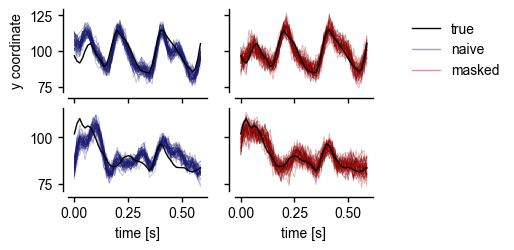

In [2]:
##################################################
#                                                #
#         panel C: example time series/ samples  #
#                                                #
##################################################

# load the data

# load the data 
seq_len = 48  # walking time series are cut into sequence length 48 time steps 
# get the correct ids of the fly limbs / key point locatoins (masked limbs)
with open(f"{fig_3_data}/store_limbs.yaml", "r", encoding="utf8") as f:
    limbs_to_store = yaml.load(f, Loader=yaml.FullLoader)
# left masked legs
with open(
    f"{fig_3_data}/left_masked_indices.yaml", "r", encoding="utf8"
) as f:
    left_masked_limbs = yaml.load(f, Loader=yaml.FullLoader)
# import multiple samples of the reconstructions
with open(
    fig_3_data
    + f"seq_len_{seq_len}_multiple_samples_multiple_recons_samples.pkl",
    "rb",
) as f:
    multiple_samples = pickle.load(f)



# select the plotting data configuration
lat = 18  # VAE latent dimension
mask_list = ["all_obs", "mask_left_claws"]  # VAE conditions naive and masked
fps = 80  # convert to seconds
time_steps = np.arange(0, seq_len) / fps

# select the limb to plot
limb_id = limbs_to_store.index(23)  # left hind claw
plot_selection = [2, 3]  # select the samples to plot
xy_id = 1  # x coordinate, 1: y coordinate y more interesting for walking
masked = True  # consider the masked runs -> get conditionals




# make 2x2 subplot of reconstructions
# plot the reconstructions for the different runs

fig, axs = plt.subplots(2, 2, figsize=cm2inch((10, 6)), sharex=True, sharey="row")

for mask_id, mask in enumerate(mask_list):

    for ind, index in enumerate(plot_selection):
        if multiple_samples[lat][mask][masked]["recs"][seq_len] == []:
            continue
        # reconstruct the masked side
        axs[ind, mask_id].plot(
            time_steps,
            multiple_samples[lat][mask][masked]["recs"][seq_len][0][
                :, index, :, limb_id, xy_id
            ].T,
            "-",
            color=col_dict[mask][masked],
            lw=0.6,
            alpha=0.3,
        )
        # true data masked side
        axs[ind, mask_id].plot(
            time_steps,
            multiple_samples[lat][mask][masked]["gt"][seq_len][0][
                index, :, limb_id, xy_id
            ],
            color="black",
            lw=1,
            label="true" if ind == 0 else None,
        )
        axs[ind, mask_id].spines["bottom"].set_position(("outward", 4))
        axs[ind, mask_id].spines["left"].set_position(("outward", 4))


# by hand set the legend entries for all plots but only add it to axs[1,1]
axs[1, 1].plot([], [], color="0.4", lw=1, label="true")
for mask in ["all_obs", "mask_left_claws"]:
    axs[0, 1].plot(
        [],
        [],
        "-",
        color=col_dict[mask][True],
        lw=1,
        alpha=0.4,
        label="naive" if mask == "all_obs" else "masked",
    )
axs[0, 1].legend(loc="upper right", bbox_to_anchor=(2.0, 1.0))
axs[1, 1].set_xlabel("time [s]")
axs[1, 0].set_xlabel("time [s]")
axs[0, 0].set_ylabel("y coordinate")


file_name = f"Figure_3_Panel_C_3_samples_masked_limbs"
# Save the figure
plt.savefig(f"{drop_dir}/{file_name}.pdf")
plt.savefig(f"{drop_dir}/{file_name}.png")
plt.savefig(f"{local_dir}/{file_name}.pdf")
plt.savefig(f"{local_dir}/{file_name}.png")

# Figure 3 panel B: PCA of the whole dataset 

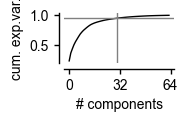

In [3]:
##################################################
#                                                #
#         panel B: Plot PCA whole data           #
#                                                #
##################################################

# load the data and compute the PCA
compute_pca_from_scratch = False
if compute_pca_from_scratch:
    from maskedvae.datasets.data_utils import get_fly_data_splits
    from sklearn.decomposition import PCA
    
    with open(os.path.join("configs/fly/fit_config.yml"), "r") as f:
        args = yaml.load(f, Loader=yaml.Loader)

    args.home = os.path.expanduser("~") + "/"
    args.seq_len = seq_len
    # Load the data and split into train, val and test
    X_train, X_val, X_test, mean_rescale, std_rescale, new_args = get_fly_data_splits(
        args
    )

    # take the PCA of the data
    X_train = X_train.reshape(-1, X_train.shape[-1])
    # normalize the data
    X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    pca = PCA(n_components=X_train.shape[-1])
    pca.fit(X_train)

    # save the pca object and load it again
    # with open(f"{fig_3_data}/pca.pkl", "wb") as f:
    #     pickle.dump(pca, f)
else:
    with open(
        f"{fig_3_data}/pca.pkl", "rb"
    ) as f:  # load pca object of the data (standardized)
        pca = pickle.load(f)




# plot the cumulative explained variance

plt.figure(figsize=cm2inch((5, 3.3)))
# make a plot with the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_), label="exp. var.", color="k")
# plot 95% explained variance horizontal line
plt.axhline(y=0.95, color="grey", linestyle="-", label="95 percent")
# get intersection with 95% explained variance
idx = np.argwhere(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]
plt.axvline(x=idx, color="grey", linestyle="-", label="95 percent")



plt.xlabel("# components")
plt.ylabel("cum. exp.var.")
plt.gca().spines["bottom"].set_position(("outward", 4))
plt.gca().spines["left"].set_position(("outward", 4))
plt.xticks([0, 32, 64])


plt.tight_layout()
file_name = f"Figure_3_Panel_B_PCA_explained_variance_95_at_{idx}"
plt.savefig(f"{drop_dir}/{file_name}.pdf")
plt.savefig(f"{drop_dir}/{file_name}.png")
plt.savefig(f"{local_dir}/{file_name}.pdf")
plt.savefig(f"{local_dir}/{file_name}.png")

# Figure 3 panel E: Calibration of the different runs

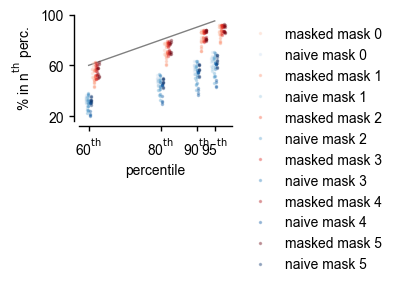

In [4]:
##################################################
#                                                #
#         panel E: Get data Calibration          #
#                                                #
##################################################

# load the indices of the masked data
with open(fig_3_data + f"masked_idx.yaml", "r") as f:
    masked_idx = yaml.load(f, Loader=yaml.FullLoader)
with open(f"{fig_3_data}/seq_len_{seq_len}_all_calibration_dict.pkl", "rb") as f:
    all_calibration_dict = pickle.load(f)


# Plot calibration for the different runs

shift_m = {}
shift_m["all_obs"] = -1  # naive
shift_m["mask_left_claws"] = 1  # masked
masked = True  # select the masked / conditional runs

label = [95, 90, 80, 60]
coord = {"x": 0, "y": 1}


# plot the calibration for the different runs

fig, axs = plt.subplots(1, 1, figsize=cm2inch((5, 3.5)), sharey=True)

# plot the diagonal
axs.plot(label, label, "grey")

# dataset length
ds_len = min(
    [
        len(all_calibration_dict[lat]["mask_left_claws"][masked]),
        len(all_calibration_dict[lat]["all_obs"][masked]),
    ]
)

# define colors blues (naive / all_obs) and reds (masked)
blues = plt.get_cmap("Blues")(np.linspace(0.2, 1, ds_len))
reds = plt.get_cmap("Reds")(np.linspace(0.2, 1, ds_len))

np.random.seed(42)
for xy, sxy in enumerate(
    [
        "x",
        "y",
    ]
):
    for ds in range(ds_len):
        for percentile in label:
            for plotmask in ["mask_left_claws", "all_obs"]:
                rand = 0.3 * np.random.rand()  # jitter the x axis
                # plot the calibration for all masked x and y coordinates
                for cc, idx in enumerate(masked_idx):
                    axs.plot(
                        shift_m[plotmask] + ds * 0.3 + rand + percentile,
                        all_calibration_dict[lat][plotmask][masked][ds][percentile][
                            idx, coord[sxy]
                        ]
                        * 100,
                        ".",
                        ms=3,
                        alpha=0.3,
                        color=blues[ds] if plotmask == "all_obs" else reds[ds],
                        label=(
                            label_dict[plotmask][masked] + " " + str(ds)
                            if percentile == 60 and cc == 0 and xy == 0
                            else ""
                        ),
                    )


axs.set_xticks(label)
axs.set_xticklabels([str(lab) + r"$^{\mathrm{th}}$" for lab in label])
axs.set_yticks([20, 60, 100])


axs.set_ylabel(r"% in n$^{\mathrm{th}}$ perc.")
axs.legend(bbox_to_anchor=(1.01, 1.0), frameon=False)
axs.set_xlabel("percentile")

# offset the axis
axs.spines["left"].set_position(("outward", 4))
axs.spines["bottom"].set_position(("outward", 4))

file_name = f"Figure_3_Panel_E_Calibration"
plt.savefig(f"{drop_dir}/{file_name}.pdf")
plt.savefig(f"{drop_dir}/{file_name}.png")
plt.savefig(f"{local_dir}/{file_name}.pdf")
plt.savefig(f"{local_dir}/{file_name}.png")

# Panel D: MSE gt reconstructed means  

In [5]:
##################################################
#                                                #
#         panel D: MSE Prediction                #
#                                                #
##################################################

# load the means of the reconstruction, i.e. the direct output of the VAE
# calculate the mean squared error from the gt to the reconstructions

with open(
    fig_3_data + f"seq_len_{seq_len}_sample_means_recons.pkl",
    "rb",
) as f:
    sample_means = pickle.load(f)
masked = True # consider the masked runs -> get conditionals

MSE_masked_indices = {mask: 0 for mask in ["all_obs", "mask_left_claws"]}

# Iterate over the dictionary
for mask, sample_dict in sample_means[lat].items():
    # only consider the masked left claws runs and naive 
    assert mask in ["all_obs", "mask_left_claws"], "skip all other possible masking patterns"
    # consider the masked runs -> get conditionals
    masked_dict = sample_dict[masked]
    
    scaling_mean = np.mean(
        masked_dict["gt"][seq_len][0][:, :, :, :], axis=1, keepdims=True
    )
    scaling_std = np.std(
        masked_dict["gt"][seq_len][0][:, :, :, :], axis=1, keepdims=True
    )

    # apply scaling to recs and gt
    masked_dict["gt"][seq_len][0] = (
        masked_dict["gt"][seq_len][0] - scaling_mean
    ) / scaling_std
    masked_dict["recs"][seq_len][0] = (
        masked_dict["recs"][seq_len][0] - scaling_mean
    ) / scaling_std

    # compute the mean squared error
    error_array_masked_idx = np.mean(
        (
            (
                masked_dict["gt"][seq_len][0][:, :, masked_idx, :]
                - masked_dict["recs"][seq_len][0][:, :, masked_idx, :]
            )
        )
        ** 2,
        axis=(1,),
    )

    MSE_masked_indices[mask] = error_array_masked_idx

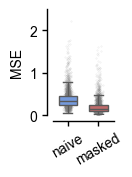

In [6]:
colors = [
    "cornflowerblue",
    "indianred",
    "steelblue",
    "darksalmon",
    "steelblue",
    "darkred",
]
customPalette = sns.set_palette(sns.color_palette(colors), desat=1)

fig, axs = plt.subplots(1, 1, figsize=cm2inch((2, 3.5)), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
limb_id = masked_idx.index(23)# left hind claw
xy_id = 1 # y coordinate
# index 3 is all observed
data_arr = [
    MSE_masked_indices["all_obs"][:, limb_id, xy_id],
    MSE_masked_indices["mask_left_claws"][:, limb_id, xy_id],
]
dp_all = len(MSE_masked_indices["all_obs"][:, limb_id, xy_id])
dp_masked = len(MSE_masked_indices["mask_left_claws"][:, limb_id, xy_id])

# set seed for reproducibility
np.random.seed(42)
plt.plot(
    np.random.normal(0, 0.05, dp_all),
    MSE_masked_indices["all_obs"][:, limb_id, xy_id],
    ".",
    ms=0.5,
    color="0.5",
    alpha=0.2,
    zorder=0,
)
plt.plot(
    np.random.normal(1, 0.05, dp_masked),
    MSE_masked_indices["mask_left_claws"][:, limb_id, xy_id],
    ".",
    ms=0.5,
    color="0.5",
    alpha=0.2,
    zorder=0,
)
sns.boxplot(
    data=data_arr,
    palette=customPalette,
    width=0.6,
    ax=axs,
    showfliers=False,
)

axs.set_ylabel("MSE")

axs.spines["left"].set_position(("outward", 4))
axs.spines["bottom"].set_position(("outward", 4))
axs.locator_params(axis="y", nbins=4)
axs.set_xticks([0, 1])
axs.set_xticklabels(["naive", "masked"])
# turn the labels by 30 degree
for tick in axs.get_xticklabels():
    tick.set_rotation(30)

plt.ylim(0, 2.5)
file_name = f"Figure_3_Panel_D_MSE_prediction"
# Save the figure
plt.savefig(f"{drop_dir}/{file_name}.pdf")
plt.savefig(f"{drop_dir}/{file_name}.png")
plt.savefig(f"{local_dir}/{file_name}.pdf")
plt.savefig(f"{local_dir}/{file_name}.png")